# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
# import libraries here; add more as necessary
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import platform
import psutil
from sklearn.utils import shuffle

# sklearn
import sklearn 
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBRegressor

from sklearn import svm
from sklearn.svm import SVC

import xgboost as xgb

#libary for subsampling techniques
import smote_variants as sv

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

#automated tuning libraries
from hpsklearn import HyperoptEstimator, gradient_boosting, ada_boost, xgboost_classification
from hyperopt import fmin, tpe, hp, anneal, Trials
from hyperopt import space_eval

# magic word for producing visualizations in notebook
%matplotlib inline

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data
azdias = pd.read_csv("Udacity_AZDIAS_052018.csv")
azdias.head()

/Users/eamankwah/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
customers = pd.read_csv("Udacity_CUSTOMERS_052018.csv")
customers.head()

/Users/eamankwah/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [6]:
# azdias data shape
azdias.shape

(891221, 366)

In [7]:
# azdias data info
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [8]:
# check  azdias object features
azdias_obj = azdias.select_dtypes(include='object')
azdias_obj.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


In [9]:
# customers Data Shape
customers.shape

(191652, 369)

In [10]:
# customer data info
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [11]:
# check customers object features
customers_obj = customers.select_dtypes(include='object')
customers_obj.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER


In [12]:
# Display a description of the azdias numerical dataset
display(azdias.describe())

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [13]:
# Display a description of customers numerical dataset
display(customers.describe())

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [14]:
azdias.dtypes

LNR                       int64
AGER_TYP                  int64
AKT_DAT_KL              float64
ALTER_HH                float64
ALTER_KIND1             float64
                         ...   
WOHNDAUER_2008          float64
WOHNLAGE                float64
ZABEOTYP                  int64
ANREDE_KZ                 int64
ALTERSKATEGORIE_GROB      int64
Length: 366, dtype: object

In [15]:
customers.dtypes

LNR                       int64
AGER_TYP                  int64
AKT_DAT_KL              float64
ALTER_HH                float64
ALTER_KIND1             float64
                         ...   
PRODUCT_GROUP            object
CUSTOMER_GROUP           object
ONLINE_PURCHASE           int64
ANREDE_KZ                 int64
ALTERSKATEGORIE_GROB      int64
Length: 369, dtype: object

In [16]:
print("Number of columns in Customers Data - ", len(list(customers.columns)))
print("Number of columns in Azdius Data - ", len(list(azdias.columns)))
extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
print("Extra columns in Customers Data - ",extra_cols_in_customers)

Number of columns in Customers Data -  369
Number of columns in Azdius Data -  366
Extra columns in Customers Data -  ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']


In [17]:
customers[extra_cols_in_customers].head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,FOOD,SINGLE_BUYER,0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0
3,COSMETIC,MULTI_BUYER,0
4,FOOD,MULTI_BUYER,0


To have a consistent dataset , i will drop those 3 extra columns from the customers dataset

In [18]:
customers = customers.drop(extra_cols_in_customers, inplace=False, axis = 1)
print("Number of columns in Customers Data - ", len(list(customers.columns)))

Number of columns in Customers Data -  366


In [19]:
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx',skiprows=[0])
attributes_values.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [20]:
attributes_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', skiprows=[0])
attributes_info.head()

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [21]:
attributes_values.drop(['Unnamed: 0'], axis=1, inplace=True)
attributes_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [22]:
attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
attributes_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


In [23]:
attributes_info.drop(['Unnamed: 0'], axis=1, inplace=True)
attributes_info.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


# Verifying Commonality

In [24]:
attributes_list = attributes_values.Attribute.unique().tolist()
azdias_list = list(azdias.columns)
customers_list = list(customers.columns)

In [25]:
common_to_all = (set(attributes_list) & set(azdias_list) & set(customers_list))
unique_to_azdias = (set(azdias_list) - set(attributes_list) - set(customers_list))
unique_to_customers = (set(customers_list) - set(attributes_list) - set(azdias_list))
unique_to_attributes = (set(attributes_list) - set(customers_list) - set(azdias_list))
unique_to_attributes_vs_azdias = (set(attributes_list) - set(azdias_list))
#unique_to_azdias_vs_attributes = (set(attributes_list) - set(azdias_list))
common_azdias_attributes = (set(azdias_list) & set(attributes_list))
print("No of columns common to all 3 daframes: ", str(len(common_to_all)))
print("No of columns specific to azdias: " + str(len(unique_to_azdias)))
print("No of columns specific to customers: " + str(len(unique_to_customers)))
print("No of columns specific to attributes: " + str(len(unique_to_attributes)))
print("No of columns common between azdias and attributes: " + str(len(common_azdias_attributes)))
print("No of columns exclusive to attributes vs azdias: " + str(len(unique_to_attributes_vs_azdias)))
#print("No of columns exclusive to azdias vs attributes: " + str(len(unique_to_azdias_vs_attributes)))

No of columns common to all 3 daframes:  272
No of columns specific to azdias: 0
No of columns specific to customers: 0
No of columns specific to attributes: 42
No of columns common between azdias and attributes: 272
No of columns exclusive to attributes vs azdias: 42


In [26]:
# check some noise associted with columns 19 and 20
# getting the name of these columns

In [27]:
print(azdias.iloc[:,18:20].columns)
print(customers.iloc[:,18:20].columns)

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')
Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')


In [28]:
#check attribut columns for these noise
attributes_values[attributes_values["Attribute"] == "CAMEO_DEUG_2015"]

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,NaN,1,upper class
53,CAMEO_DEUG_2015,NaN,2,upper middleclass
54,CAMEO_DEUG_2015,NaN,3,established middleclasse
55,CAMEO_DEUG_2015,NaN,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,NaN,5,active middleclass
57,CAMEO_DEUG_2015,NaN,6,low-consumption middleclass
58,CAMEO_DEUG_2015,NaN,7,lower middleclass
59,CAMEO_DEUG_2015,NaN,8,working class
60,CAMEO_DEUG_2015,NaN,9,urban working class


In [29]:
attributes_values[attributes_values["Attribute"] == "CAMEO_DEUINTL_2015"]

,Attribute,Description,Value,Meaning
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
106,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
107,CAMEO_DEUINTL_2015,NaN,12,Wealthy Households-Young Couples With Children
108,CAMEO_DEUINTL_2015,NaN,13,Wealthy Households-Families With School Age Ch...
109,CAMEO_DEUINTL_2015,NaN,14,Wealthy Households-Older Families & Mature Co...
110,CAMEO_DEUINTL_2015,NaN,15,Wealthy Households-Elders In Retirement
111,CAMEO_DEUINTL_2015,NaN,21,Prosperous Households-Pre-Family Couples & Sin...
112,CAMEO_DEUINTL_2015,NaN,22,Prosperous Households-Young Couples With Children
113,CAMEO_DEUINTL_2015,NaN,23,Prosperous Households-Families With School Age...
114,CAMEO_DEUINTL_2015,NaN,24,Prosperous Households-Older Families & Mature ...


The two tables appear to show that those two columns have value of -1 for unknown and an integer value for respective category. I will therefore create a noise column for these columns

In [30]:
noise_column = list(azdias.columns[18:20])

#Let me check the unique values for these noise column in the azdias and customer dataframes

In [31]:
azdias[noise_column[0]].unique()


array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [32]:
azdias[noise_column[1]].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [33]:
customers[noise_column[0]].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [34]:
customers[noise_column[1]].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

In the attributes dataframe, unknown values are treated as '-1',I will replace these X and XX with nan values and then
to make analysis simple, the -1 values can also be treated as nans.

## Exploratory Analysis of Attribute Values

In [35]:
attributes_values.head(5)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


The above shows the attribute name, description of the column, the ranges of the values collected and the 
the meaning ascribed to the respective values.

The name of the attributes and their descriptions will aid in the cleanup process of the azdias and customers datasets.I will use pandas 'dropna'
to replace all unknown values with nans.

In [36]:
attributes_values.dropna()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


## Data Cleaning and Feature Engineering

### Missing values


Analysing missing values will help to determine which features to drop and to retain in the model. 

In [37]:
azdias.isna().sum()

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               73499
ALTER_HH                 73499
ALTER_KIND1             810163
                         ...  
WOHNDAUER_2008           73499
WOHNLAGE                 93148
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 366, dtype: int64

In [38]:
customers.isna().sum()

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               46596
ALTER_HH                 46596
ALTER_KIND1             179886
                         ...  
WOHNDAUER_2008           46596
WOHNLAGE                 49927
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 366, dtype: int64

There above shows that there are a lot of missing column values that need to be investigated further.

In [39]:
azdias_missing_percent = azdias.isna().sum() * 100/ len(azdias)
df_azdias_missing_percent = pd.DataFrame({"Attribute": azdias.columns,"Missing_Percentage":\
                                          azdias_missing_percent}).reset_index(drop=True)

In [40]:
azdias_missing_report = df_azdias_missing_percent[azdias]

In [41]:
print("No of columns with missing values from azdias - ", \
      len(df_azdias_missing_percent[df_azdias_missing_percent.Missing_Percentage > 0]))

No of columns with missing values from azdias -  273


In [42]:
customers_missing_percent = customers.isna().sum() * 100/ len(customers)
df_customers_missing_percent = pd.DataFrame({"Attribute": customers.columns,"Missing_Percentage":\
                                          customers_missing_percent}).reset_index(drop=True)

customers_missing_report = df_azdias_missing_percent[customers]

In [43]:
print("No of columns with missing values from customers - ", \
      len(df_customers_missing_percent[df_customers_missing_percent.Missing_Percentage > 0]))

No of columns with missing values from customers -  273


### Azdias and Customer dataframes vs missing percentages

**Column missing values**

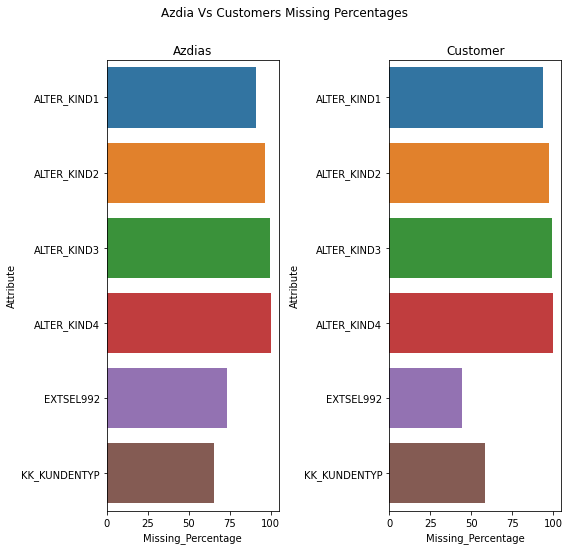

In [44]:
percentage = 30
figsize = 8,8
fig = plt.figure(figsize=figsize)
fig.suptitle("Azdia Vs Customers Missing Percentages")

ax = fig.add_subplot(121)
ax.set_title("Azdias")
sns.barplot(y="Attribute", x="Missing_Percentage",\
            data=df_azdias_missing_percent[df_azdias_missing_percent.Missing_Percentage>percentage], ax= ax)

ax = fig.add_subplot(122)
ax.set_title("Customer")
sns.barplot(y="Attribute", x="Missing_Percentage",\
            data=df_customers_missing_percent[df_customers_missing_percent.Missing_Percentage>percentage], ax= ax)
fig.tight_layout(rect=[0, 0.03, 1, 0.975])
plt.show()

Both datasets has 6 features with more more than 30% missing values. The 6 features represent 2.2% (6*100/273)  
out of the total number of missing values.Hence removing 30% out of the azdias and customers data 
sets will not significantly affect future analysis


In [45]:
remove_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4','EXTSEL992','KK_KUNDENTYP']

In [46]:
print("Number of columns prior to dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

Number of columns prior to dropping
Azdias - 366
Customers - 366


In [47]:
azdias = azdias.drop(remove_cols, axis = 1)
customers = customers.drop(remove_cols, axis = 1)

In [48]:
print("Number of columns after to dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

Number of columns after to dropping
Azdias - 360
Customers - 360


It is confirmed from th above that the 6 columns have been removed

**Row missing values**

#Missind data per column

In [49]:
print(azdias.shape)

print(customers.shape)

(891221, 360)
(191652, 360)


In [50]:
row_miss = azdias.isnull().sum(axis=1)

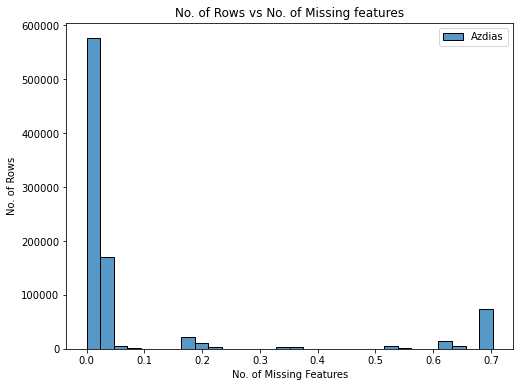

In [51]:
fig = plt.figure(figsize=(8,6))
plt.title("No. of Rows vs No. of Missing features")
plt.xlabel("No. of Missing Features")
plt.ylabel("No. of Rows")
sns.histplot(row_miss.values/360, bins=30,kde=False, label="Azdias")
plt.legend()
plt.show()

In [52]:
row_miss_c = customers.isnull().sum(axis=1)

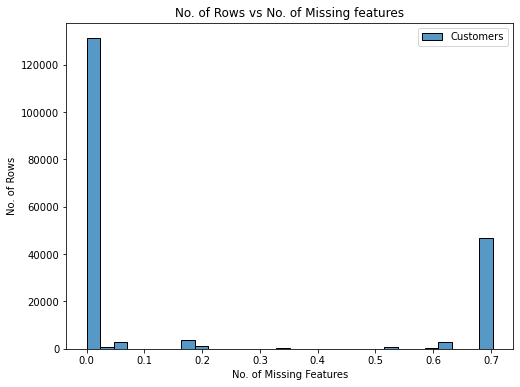

In [53]:
fig = plt.figure(figsize=(8,6))
plt.title("No. of Rows vs No. of Missing features")
plt.xlabel("No. of Missing Features")
plt.ylabel("No. of Rows")
sns.histplot(row_miss_c.values/360, bins=30,kde=False, label="Customers")
plt.legend()
plt.show()

From the above plotd we can conclude, there are about 252 (07*360) feastures missing 
out of 891221 and 191652 rows for azdias and customers dataset, repectively. Missing rows in
azdias are more than customers.

Since majority of the rows have 50 or less values, I will drop all rows with more than 50 missing values

In [54]:
# Drop row that contains more than 50% of missing values in azdias
azdias = azdias.loc[row_miss[row_miss <= 0.5*360].index]
azdias.reset_index(drop=True, inplace=True)

In [55]:
# Drop row that contains more than 50% of missing values in customers
customers = customers.loc[row_miss_c[row_miss_c <= 0.5*360].index]
customers.reset_index(drop=True, inplace=True)

In [56]:
print(azdias.shape)

print(customers.shape)

(792027, 360)
(140903, 360)


The number of azdias dataframe has reduced from 891,221 to 792,027 and the number 
of customers dataframe has reduced from 191,652 to 140, 903

### Data Types

In [57]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792027 entries, 0 to 792026
Columns: 360 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(261), int64(93), object(6)
memory usage: 2.1+ GB


In [58]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140903 entries, 0 to 140902
Columns: 360 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(261), int64(93), object(6)
memory usage: 387.0+ MB


Both datasets have 6 object type data set that can be exploited for more insights.

In [59]:
azdias_obj_cols = azdias.columns[azdias.dtypes == "object"]
customer_obj_cols = customers.columns[customers.dtypes == "object"]

In [60]:
print("Azdias object columns names\n",azdias_obj_cols.values)
print('-----------------------------------------------')
print("Customers object columns names\n",customer_obj_cols.values)

Azdias object columns names
 ['CAMEO_DEU_2015' 'CAMEO_DEUG_2015' 'CAMEO_INTL_2015'
 'D19_LETZTER_KAUF_BRANCHE' 'EINGEFUEGT_AM' 'OST_WEST_KZ']
-----------------------------------------------
Customers object columns names
 ['CAMEO_DEU_2015' 'CAMEO_DEUG_2015' 'CAMEO_INTL_2015'
 'D19_LETZTER_KAUF_BRANCHE' 'EINGEFUEGT_AM' 'OST_WEST_KZ']


In [61]:
#looping through the azdias object columns
for col in azdias_obj_cols:
    print("\nColumn ",col)
    print(azdias[col].value_counts())


Column  CAMEO_DEU_2015
6B    56427
8A    52330
4C    47498
2D    34877
3C    34564
7A    34246
3D    34113
8B    33315
4A    32870
8C    30925
9D    28539
9B    27624
9C    24952
7B    24405
9A    20506
2C    19253
8D    17541
6E    16060
2B    15345
5D    14861
6C    14755
2A    13155
5A    11950
1D    11871
1A    10783
5B    10294
3A    10129
5C     9842
7C     9033
4B     8978
4D     8534
3B     7027
6A     6770
9E     6322
6D     6058
6F     5359
7D     5313
4E     5287
1E     5033
7E     4606
1C     4290
5F     4260
1B     4046
5E     3567
XX      353
Name: CAMEO_DEU_2015, dtype: int64

Column  CAMEO_DEUG_2015
8      77818
9      62449
6      61015
4      59735
8.0    56293
3      49815
2      47931
9.0    45494
7      44826
6.0    44414
4.0    43432
3.0    36018
2.0    34699
7.0    32777
5      31967
5.0    22807
1      20887
1.0    15136
X        353
Name: CAMEO_DEUG_2015, dtype: int64

Column  CAMEO_INTL_2015
51      77429
51.0    56016
41      53241
24      52554
41.0    3872

* CAMEO_DEUG_2015 contains mixed types and also contained ungrouped topology information that need to be worked on. 
* CAMEO_INTL_2015 contains mixed types and information on wealth and stage that has to be probed further.
* EINGEFUEGT_AM has time data that can be analysis to see distribution over time.
* OST_WEST_KZ contains german history information even before unification. it may be valuable for customer segmentation.
* D19_LETZTER_KAUF_BRANCHE contains information about the lastest branch purchases were made but has several levels of data that can significantly increase the number of feature
if included. 
* CAMEO_DEU_2015 contains the groupings an indivual may belong to an also has similiar multi levels like D19_LETZTER_KAUF_BRANCHE. 

Hence D19_LETZTER_KAUF_BRANCHE and CAMEO_DEU_2015 will be removed as shown below:

In [62]:
remove_more_cols = ['D19_LETZTER_KAUF_BRANCHE','CAMEO_DEU_2015']

In [63]:
print("Number of columns prior to dropping")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

Number of columns prior to dropping
Azdias - 360
Customers - 360


In [64]:
azdias = azdias.drop(remove_more_cols, axis = 1)
customers = customers.drop(remove_more_cols, axis = 1)

In [65]:
print("Number of columns after dropping 2 columns")
print(f"Azdias - {len(azdias.columns)}")
print(f"Customers - {len(customers.columns)}")

Number of columns after dropping 2 columns
Azdias - 358
Customers - 358


### Fixing Unknown Values

The are specific representations recoreded in the attributes-values dataset for unknown
values. Find below the number of nunknows in the attribute dataframe.

In [66]:
attrib_unknown_values = attributes_values[attributes_values["Meaning"] == "unknown"]
print(len(attrib_unknown_values))

232


In [67]:
attrib_unknown_values

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
...,...,...,...,...
2219,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,WOHNLAGE,residential-area,-1,unknown
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


In [68]:
azdias.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910220,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
1,910225,-1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
2,910226,2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
3,910241,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
4,910244,3,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


In [69]:
def unknown_rep(att, attrib_unknown_values):
    """Returns unknown values representation"""
    unknown = attrib_unknown_values[attrib_unknown_values["Attribute"] == att]["Value"]
    unknown = unknown.astype(str).str.cat(sep=",")
    unknown = [int(i) for i in unknown.split(",")]
    return [unknown]

In [70]:
unknown_ager_typ = unknown_rep("AGER_TYP", attrib_unknown_values)
print(unknown_ager_typ)

[[-1]]


The attribute AGER_TYP has a lot of unknown values (-1) that has to be changed to nan.

In [71]:
def unknown_to_nan(val, unknown):
    """Replaces unkown values with nans"""
    return np.nan if val in unknown else val
    

In [72]:
azdias["AGER_TYP"] = azdias["AGER_TYP"].apply(unknown_to_nan, args=(unknown_ager_typ))

In [73]:
azdias.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910220,NaN,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
1,910225,NaN,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
2,910226,2.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
3,910241,NaN,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
4,910244,3.0,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


All the 232 columns with unknown values can now be changed to nan

In [74]:
def unknowns_rep(df, unkown_attributes_values, verbose=False):
    """
    Replace unknown values with nans in the list of unknown_attributes_values.
    """
    for att in attrib_unknown_values.Attribute:
        unknown = unknown_rep(att, attrib_unknown_values)
        if att in df.columns:
            df[att] = df[att].apply(unknown_to_nan, args=(unknown))
    return df

In [75]:
azdias = unknowns_rep(azdias, attrib_unknown_values)

In [76]:
customers = unknowns_rep(customers, attrib_unknown_values)

* Fixing CAMEO_DEUG_2015 and CAMEO_INTL_2015 attribute value  X and XX

In [77]:
def cameo_rep(df):
    """Repace 'X' and 'XX' with nans"""
    cameo = ["CAMEO_INTL_2015", "CAMEO_DEUG_2015"]
    df[cameo] = df[cameo].replace({"XX": np.nan, "X": np.nan})
    df[cameo] = df[cameo].astype(float)
    return df

In [78]:
azdias = cameo_rep(azdias)
customers = cameo_rep(customers)

In [79]:
azdias[noise_column[1]].unique()

array([51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34., 55.,
       25., nan, 23., 31., 52., 35., 45., 44., 32.])

In [80]:
customers[noise_column[0]].unique()

array([ 1.,  5.,  4.,  7.,  3.,  9.,  2.,  6.,  8., nan])

In [81]:
print(azdias.shape)
print(customers.shape)

(792027, 358)
(140903, 358)


* The distribution of EINGEFUEGT_AM

In [82]:
def eigefugt_distr (df):
    df["EINGEFUEGT_AM"] = pd.to_datetime(df["EINGEFUEGT_AM"])
    df["EINGEFUEGT_AM"] = df['EINGEFUEGT_AM'].map(lambda x: x.year)
    return df

In [83]:
azdias = eigefugt_distr(azdias)
customers = eigefugt_distr(customers)

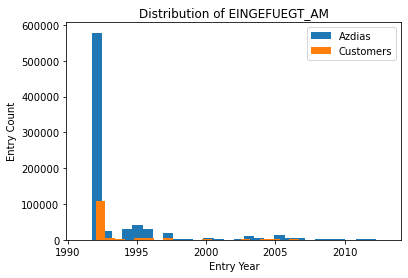

In [84]:
plt.hist(azdias["EINGEFUEGT_AM"], bins=30, label="Azdias")
plt.hist(customers["EINGEFUEGT_AM"], bins=30, label="Customers")
plt.ylabel("Entry Count")
plt.xlabel("Entry Year")
plt.title("Distribution of EINGEFUEGT_AM")
plt.legend()

* WOHNLAGE column encoding



In [85]:
azdias.WOHNLAGE.value_counts()

3.0    248511
7.0    168650
4.0    135359
2.0     99897
5.0     73930
1.0     43687
8.0     16611
0.0      5382
Name: WOHNLAGE, dtype: int64

There is no score calculated for 5382 rows, hence will be coded as nans.

In [86]:
def wohnlage_rep(df):
    """ Replace '0' with nan" """
    df["WOHNLAGE"] = df["WOHNLAGE"].replace({0: np.nan})
    return df

In [87]:
azdias = wohnlage_rep(azdias)
customers = wohnlage_rep(customers)

In [88]:
azdias.WOHNLAGE.value_counts()

3.0    248511
7.0    168650
4.0    135359
2.0     99897
5.0     73930
1.0     43687
8.0     16611
Name: WOHNLAGE, dtype: int64

* Cleaning the LP family

The P family has a multi level attributes with a lot of values that are not present in the attribute discription. There is a sublevel "FEIN" and sublevel "GROB" which appears to contian the same information. I will check the unique attribute values in order to decide the attribute to drop and the attribute to investigate further.

In [89]:
print(azdias.LP_FAMILIE_FEIN.unique())
print(azdias.LP_FAMILIE_GROB.unique())
print(azdias.LP_STATUS_FEIN.unique())
print(azdias.LP_STATUS_GROB.unique())
print(azdias.LP_LEBENSPHASE_FEIN.unique())
print(azdias.LP_LEBENSPHASE_GROB.unique())



[ 5.  1.  0. 10.  2.  7. 11.  8.  4.  6. nan  9.  3.]
[ 3.  1.  0.  5.  2.  4. nan]
[ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
[ 1.  2.  4.  5.  3. nan]
[21.  3.  0. 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 25. 13. 18. 31.
 38. 35. 30.  7. 22. 14. 29. 24. 28. 37. 26. 39. 27. 36.  9. 34. 33. 15.
 nan 11. 40. 16. 19. 17.]
[ 6.  1.  0. 10.  2.  3.  5.  7. 12. 11.  9.  4.  8. nan]


For consistency sake, I will recode the FEIN sublevels and drop out the GROB sublevels

In [90]:
def lp_rep(df):
    """
    Replace 0s with nan values columns and delete GROB family]
    """
    
    # drop the GROB subattributes
    df.drop("LP_FAMILIE_GROB", axis=1, inplace=True)
    df.drop("LP_STATUS_GROB", axis=1, inplace=True)
    df.drop("LP_LEBENSPHASE_GROB", axis=1, inplace=True)
    
    # Replacing '0' with NaNs
    cols = ["LP_FAMILIE_FEIN", "LP_STATUS_FEIN", "LP_LEBENSPHASE_FEIN"]
    
    df[cols] = df[cols].replace({0: np.nan})
    df[cols] = df[cols].astype(float)
    
    # LP_FAMILIE_FEIN
    family = {1:'single', 2:'couple', 3:'singleparent', 4:'singleparent', 5:'singleparent', 
                  6:'family', 7:'family', 8:'family', 9:'multifamily', 10:'multifamily', 11:'multifamily'}
        
    df["LP_family"] = df["LP_FAMILIE_FEIN"].map(family)
    
    # Drop LP_FAMILIE_FEIN
    df.drop('LP_FAMILIE_FEIN', axis=1, inplace=True)
    
    # recode LP_family as ordinal
    tmp_family = {'single': 1, 'couple': 2, 'singleparent': 3,'family': 4, 'multifamily':5}
    df['LP_family'] = df['LP_family'].map(tmp_family)
    
    
    # LP_STATUS_FEIN    
    income = {1:'lowincome', 2:'lowincome', 3:'midincome', 4:'midincome', 5:'midincome', 
                  6:'indep', 7:'indep', 8: 'owner', 9: 'owner', 10: 'topE'}
       
    df["LP_income"] = df["LP_STATUS_FEIN"].map(income)
    
    # Drop LP_income
    df.drop('LP_STATUS_FEIN', axis=1, inplace=True)
    
    # recode LP_income as ordinal
    tmp_status = {'lowincome': 1, 'midincome': 2, 'indep': 3, 'owner': 4, 'topE':5}

    df['LP_income'] = df['LP_income'].map(tmp_status)
    
      
    # LP_LEBENSPHASE_FEIN
    age_stages = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

    wealth_levels = {1: 'low', 2: 'low', 3: 'middle', 4: 'middle', 5: 'low', 6: 'low',
              7: 'middle', 8: 'middle', 9: 'middle', 10: 'wealthy', 11: 'middle',
              12: 'middle', 13: 'top', 14: 'middle', 15: 'low', 16: 'middle',
              17: 'middle', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'middle', 23: 'wealthy', 24: 'low', 25: 'middle', 26: 'middle',
              27: 'middle', 28: 'top', 29: 'low', 30: 'middle', 31: 'low',
              32: 'middle', 33: 'middle', 34: 'middle', 35: 'top', 36: 'middle',
              37: 'middle', 38: 'middle', 39: 'top', 40: 'top'}
    
    
    df['LP_age_stages'] = df['LP_LEBENSPHASE_FEIN'].map(age_stages)
    df['LP_wealth_levels'] = df['LP_LEBENSPHASE_FEIN'].map(wealth_levels)
   
    # Drop LP_LEBENSPHASE_FEIN
    df.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
    
    # Recoding LP_aage_stages and LP_wealth_levesl
    tmp_age_stages = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3, 'retirement_age': 4}
    tmp_wealth_levels = {'low': 1, 'middle': 2, 'wealthy': 3, 'top': 4}
    df['LP_age_stages'] = df['LP_age_stages'].map(tmp_age_stages)
    df['LP_wealth_levels'] = df['LP_wealth_levels'].map(tmp_wealth_levels)
    
    return df

In [91]:
azdias = lp_rep(azdias)

In [92]:
customers = lp_rep(customers)

## Feature Engineering Categorical Variables

### CAMEO_INTL_2015 column Encoding

This feature contains mixed types of information that has to be seperated.

In [93]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_family,LP_income,LP_age_stages,LP_wealth_levels
0,910220,NaN,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,...,3.0,9.0,4.0,5,2,1,3.0,1.0,2.0,1.0
1,910225,NaN,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,...,3.0,9.0,2.0,5,2,3,1.0,2.0,1.0,2.0
2,910226,2.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,...,NaN,9.0,7.0,3,2,4,NaN,4.0,NaN,NaN
3,910241,NaN,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,...,2.0,9.0,3.0,4,1,3,5.0,2.0,3.0,2.0
4,910244,3.0,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,...,6.0,9.0,7.0,4,2,1,1.0,2.0,4.0,2.0


In [94]:
def cameo_intl_rep(val):
    if np.isnan(val):
        return [np.nan, np.nan]
    else:
        val = str(val).split('.')[0]
        return [int(val[0]), int(val[1])]
    
azdias["CAMEO_INTL_2015"] = azdias["CAMEO_INTL_2015"].apply(lambda x: float(x))
azdias["CAMEO_INTL_2015"] = azdias["CAMEO_INTL_2015"].apply(cameo_intl_rep)

# CAMEO_INTL_2015 Wealth Levels and CAMEO_INTL_2015 Age Stages
azdias["CAMEO_INTL_2015_wlevels"] = azdias["CAMEO_INTL_2015"].apply(lambda x: x[0])
azdias["CAMEO_INTL_2015_astages"] = azdias["CAMEO_INTL_2015"].apply(lambda x: x[1])

# drop CAMEO_INTL_2015
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [95]:
def cameo_intl_rep(val):
    if np.isnan(val):
        return [np.nan, np.nan]
    else:
        val = str(val).split('.')[0]
        return [int(val[0]), int(val[1])]
    
customers["CAMEO_INTL_2015"] = customers["CAMEO_INTL_2015"].apply(lambda x: float(x))
customers["CAMEO_INTL_2015"] = customers["CAMEO_INTL_2015"].apply(cameo_intl_rep)

# CAMEO_INTL_2015 Wealth Levels and CAMEO_INTL_2015 Age Stages
customers["CAMEO_INTL_2015_wlevels"] = customers["CAMEO_INTL_2015"].apply(lambda x: x[0])
customers["CAMEO_INTL_2015_astages"] = customers["CAMEO_INTL_2015"].apply(lambda x: x[1])

# drop CAMEO_INTL_2015
customers.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [96]:
azdias['CAMEO_INTL_2015_wlevels'].unique()

array([ 5.,  2.,  1.,  4.,  3., nan])

In [97]:
azdias['CAMEO_INTL_2015_astages'].unique()

array([ 1.,  4.,  2.,  3.,  5., nan])

In [98]:
customers['CAMEO_INTL_2015_wlevels'].unique()

array([ 1.,  3.,  2.,  4.,  5., nan])

In [99]:
customers['CAMEO_INTL_2015_astages'].unique()

array([ 3.,  4.,  1.,  5.,  2., nan])

* Label encoding the ANRADE_KZ feature values (1, 2) with (0, 1)

In [100]:
azdias['ANREDE_KZ'].unique()

array([2, 1])

In [101]:
def anrede_rep(df):
    """ Label encode "ANREDE_KZ" """
    df["ANREDE_KZ"] = df["ANREDE_KZ"].replace({1: 0, 2: 1})
    return df

In [102]:
azdias = anrede_rep(azdias)
customers = anrede_rep(customers)

* **Label encoding the OST_WEST_KZ feature values (W, 0) with (0, 1)**

In [103]:
azdias['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [104]:
def ost_west_rep(df):
    """ Label encode "OST_WEST_KZ"""
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    return df

In [105]:
azdias = ost_west_rep(azdias)
customers = ost_west_rep(customers)

In [106]:
print("\nTotal number of missing values of the azdias DataFrame:")
print(azdias.isna().sum().sum())


Total number of missing values of the azdias DataFrame:
7930552


In [107]:
print("\nTotal number of missing values of the customers DataFrame:")
print(customers.isna().sum().sum())


Total number of missing values of the customers DataFrame:
850610


In [108]:
# Check the shape of azdias and customers dataframes
print(azdias.shape, customers.shape)

(792027, 357) (140903, 357)


* **Centering and replacing missing values**

In [109]:
%%time
imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
azdias = pd.DataFrame(imp.fit_transform(azdias), columns = azdias.columns)


CPU times: user 20.6 s, sys: 13.6 s, total: 34.2 s
Wall time: 35.5 s


In [110]:
%%time
customers = pd.DataFrame(imp.transform(customers), columns = customers.columns)


CPU times: user 801 ms, sys: 911 ms, total: 1.71 s
Wall time: 1.71 s


In [111]:
print(azdias.shape, customers.shape)


(792027, 357) (140903, 357)


In [112]:
azdias.dtypes

LNR                        float64
AGER_TYP                   float64
AKT_DAT_KL                 float64
ALTER_HH                   float64
ALTERSKATEGORIE_FEIN       float64
                            ...   
LP_income                  float64
LP_age_stages              float64
LP_wealth_levels           float64
CAMEO_INTL_2015_wlevels    float64
CAMEO_INTL_2015_astages    float64
Length: 357, dtype: object

* **Save cleaned dataframes**

In [113]:
#azdias.to_csv('clean_Azdias.csv', index=False)
#customers.to_csv('clean_Customers.csv', index=False)

## Creating a Data Cleaning Function

All the previous steps of fixing missing data, fixing noise and columns, replacing unknown
values and encoding categorical and mixed objects can be pushed in one function so that the
data training and testing can be done uniformly.


In [114]:
# Load original datasets
azdias = pd.read_csv("Udacity_AZDIAS_052018.csv")
customers = pd.read_csv("Udacity_CUSTOMERS_052018.csv")
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx',skiprows=[0])

/Users/eamankwah/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [115]:
def clean_func(azdias, customers, attributes_values):
    """ 
    Function for feature cleaning, encoding and engineering 
    Input = original azdias and customers datasets
    Output = cleaned azdias and customers dataset
    """
       
    start = time.time()
    
    # Separate and drop extra columns from Customers 
    extra_cols_in_customers = [col for col in customers.columns if col not in azdias.columns]
    customers = customers.drop(extra_cols_in_customers, inplace=False, axis = 1)
        
    # Fill attribute_values dataframe to help find corresponding values information
    attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
    
    # Observing noise columns 18 and 19 with warnings
    noise_column = list(azdias.columns[18:20])
            
    # Drop missing columns   
    remove_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4','EXTSEL992','KK_KUNDENTYP']
    azdias = azdias.drop(remove_cols, axis = 1)
    customers = customers.drop(remove_cols, axis = 1)
    
    # Missing rows 
    # Drop row that contains more than 50% of missing values in azdias
    row_miss = azdias.isnull().sum(axis=1)
    azdias = azdias.loc[row_miss[row_miss <= 0.5*360].index]
    azdias.reset_index(drop=True, inplace=True)
    
    # Drop row that contains more than 50% of missing values in customers
    row_miss_c = customers.isnull().sum(axis=1)
    customers = customers.loc[row_miss_c[row_miss_c <= 0.5*360].index]
    customers.reset_index(drop=True, inplace=True)

    # Remove features with less information,warnings and too much granularity
    remove_more_cols = ['D19_LETZTER_KAUF_BRANCHE','CAMEO_DEU_2015']
    azdias = azdias.drop(remove_more_cols, axis = 1)
    customers = customers.drop(remove_more_cols, axis = 1)
    
    # Fix unknown values with nans
    attrib_unknown_values = attributes_values[attributes_values["Meaning"] =="unknown"]
    azdias = unknowns_rep(azdias, attrib_unknown_values)
    customers = unknowns_rep(customers, attrib_unknown_values)
    
    # Fix CAMEO_DEUG_2015 and CAMEO_INTL_2015 attributes
    azdias = cameo_rep(azdias)
    customers = cameo_rep(customers)
    
    # Fix eigefugt feature
    azdias = eigefugt_distr(azdias)
    customers = eigefugt_distr(customers)
    
    # Wohnlage column encoding
    azdias = wohnlage_rep(azdias)
    customers = wohnlage_rep(customers)
    
    # Drop and encode lp columns
    azdias = lp_rep(azdias)
    customers = lp_rep(customers)
    
    # Encode Cameo_intl-2015
    
    # azdias data
    azdias["CAMEO_INTL_2015"] = azdias["CAMEO_INTL_2015"].apply(lambda x: float(x))
    azdias["CAMEO_INTL_2015"] = azdias["CAMEO_INTL_2015"].apply(cameo_intl_rep)

    # CAMEO_INTL_2015 Wealth Levels and CAMEO_INTL_2015 Age Stages
    azdias["CAMEO_INTL_2015_wlevels"] = azdias["CAMEO_INTL_2015"].apply(lambda x: x[0])
    azdias["CAMEO_INTL_2015_astages"] = azdias["CAMEO_INTL_2015"].apply(lambda x: x[1])

    # drop CAMEO_INTL_2015
    azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # customers data
    customers["CAMEO_INTL_2015"] = customers["CAMEO_INTL_2015"].apply(lambda x: float(x))
    customers["CAMEO_INTL_2015"] = customers["CAMEO_INTL_2015"].apply(cameo_intl_rep)

    # CAMEO_INTL_2015 Wealth Levels and CAMEO_INTL_2015 Age Stages
    customers["CAMEO_INTL_2015_wlevels"] = customers["CAMEO_INTL_2015"].apply(lambda x: x[0])
    customers["CAMEO_INTL_2015_astages"] = customers["CAMEO_INTL_2015"].apply(lambda x: x[1])

    # drop CAMEO_INTL_2015
    customers.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # Encod Anrede feature
    azdias = anrede_rep(azdias)
    customers = anrede_rep(customers)

    # Label encode ost_west feature
    azdias = ost_west_rep(azdias)
    customers = ost_west_rep(customers)

    # Imputing Missing data
    imp = SimpleImputer(strategy="most_frequent")

    azdias = pd.DataFrame(imp.fit_transform(azdias), columns = azdias.columns)
    customers = pd.DataFrame(imp.transform(customers), columns = customers.columns)
    
    end = time.time()
    
    print(f"Completed Cleaning in {end-start} seconds")
    
    return azdias, customers

In [116]:
azdias, customers = clean_func(azdias, customers, attributes_values)

Completed Cleaning in 225.77465081214905 seconds


In [117]:
print(azdias.shape)
print(customers.shape)

(792027, 357)
(140903, 357)


The results above show that the clean function is working well

* **Drop LNR(identity) column**

In [118]:
len(azdias.LNR.unique()), len(azdias)

(792027, 792027)

In [119]:
len(customers.LNR.unique()), len(customers)

(140903, 140903)

The total number of unique values in LNR column is equal to the total length of corresponding dataframe.
This means that it contains unique values for each row. Therefore this identity feature will be dropped it.

In [120]:
azdias = azdias.drop("LNR", axis=1)
customers = customers.drop("LNR", axis=1)

* **Check Azdias data ranges**

In [121]:
azdias_range = azdias.describe()

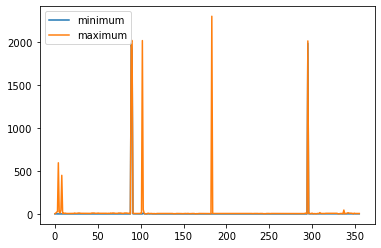

In [122]:
plt.figure()
plt.plot(azdias_range.loc['min'].values, label='minimum')
plt.plot(azdias_range.loc['max'].values, label='maximum')
plt.legend()
plt.show()

The range of the features are wide, hence i will scale the dataset so that all features can have similar weight 
imput

### Feature Scaling

In [123]:
azdias.dtypes

AGER_TYP                   float64
AKT_DAT_KL                 float64
ALTER_HH                   float64
ALTERSKATEGORIE_FEIN       float64
ANZ_HAUSHALTE_AKTIV        float64
                            ...   
LP_income                  float64
LP_age_stages              float64
LP_wealth_levels           float64
CAMEO_INTL_2015_wlevels    float64
CAMEO_INTL_2015_astages    float64
Length: 356, dtype: object

In [124]:
scaler = StandardScaler()
azdias = pd.DataFrame(scaler.fit_transform(azdias.values),columns=azdias.columns)
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

In [125]:
customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_family,LP_income,LP_age_stages,LP_wealth_levels,CAMEO_INTL_2015_wlevels,CAMEO_INTL_2015_astages
0,0.216559,-0.939631,-0.114549,-0.886846,-0.467358,-0.125318,-0.306275,0.233033,-0.461699,-0.06066,...,1.527326,-0.271694,-1.044111,1.093518,-0.192018,1.690912,0.528089,2.15286,-1.551629,0.092975
1,0.216559,-0.939631,-0.638482,-3.110949,-0.467358,-0.125318,-0.306275,-0.630522,-0.461699,-0.06066,...,-1.085940,-0.271694,0.957753,1.093518,-0.784376,1.690912,0.528089,2.15286,-0.187755,0.764992
2,-2.228769,-0.939631,-0.376516,-1.331667,-0.531155,-0.125318,-0.306275,-1.494077,-0.461699,-0.06066,...,1.527326,-1.692916,-1.044111,1.093518,-0.784376,1.029024,0.528089,0.04558,-0.869692,0.764992
3,0.216559,-0.939631,1.195283,0.002795,-0.084570,-0.125318,-0.306275,1.960143,-0.044272,-0.06066,...,-0.563287,-1.692916,-1.044111,0.168123,1.585058,-0.956638,0.528089,-1.00806,0.494183,-1.251058
4,-2.228769,-0.939631,0.016434,-0.886846,-0.467358,-0.125318,-0.306275,0.233033,-0.461699,-0.06066,...,-1.608593,-0.982305,-1.044111,0.168123,-0.192018,0.367137,-0.471843,0.04558,-0.187755,0.764992


In [126]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_family,LP_income,LP_age_stages,LP_wealth_levels,CAMEO_INTL_2015_wlevels,CAMEO_INTL_2015_astages
0,0.216559,1.257375,-1.424381,1.559667,0.170621,-0.125318,-0.306275,0.233033,0.303584,-0.06066,...,-0.040634,1.149528,0.957753,-1.682667,0.400341,-0.956638,-0.471843,-1.00806,1.176120,-1.251058
1,0.216559,1.257375,0.802333,0.670026,0.106823,-0.125318,-0.306275,-0.630522,-0.044272,-0.06066,...,-1.085940,1.149528,0.957753,0.168123,-0.784376,-0.294751,-1.471776,0.04558,-0.869692,0.764992
2,0.216559,-0.939631,0.278400,-0.219615,-0.467358,-0.125318,-0.306275,-1.494077,-0.392128,-0.06066,...,1.527326,-0.271694,0.957753,1.093518,-0.784376,1.029024,0.528089,0.04558,-1.551629,-0.579041
3,0.216559,-0.939631,1.195283,0.002795,-0.339762,-0.125318,-0.306275,1.960143,-0.322557,-0.06066,...,-0.563287,0.438917,-1.044111,0.168123,1.585058,-0.294751,0.528089,0.04558,0.494183,0.092975
4,2.661886,-0.939631,-0.114549,-0.886846,-0.212166,-0.125318,-0.306275,-0.630522,-0.392128,-0.06066,...,1.527326,0.438917,0.957753,-1.682667,-0.784376,-0.294751,1.528021,0.04558,1.176120,0.764992


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Dimensionality Reduction

In [127]:
# Apply PCA to the data.
print("Current number of features: ", azdias.shape[1])
pca = PCA().fit(azdias)

Current number of features:  356


The number of features in the current data set is high and may require hight  computation power during modelling 
training. Dimensionality reduction technique can be used to verify the variance explained by each of the features 
in the dataset. The Principal Component  Analysis (PCA), a linear technique can be used to trim down  a number 
of the features that may contribte not much to explain the variability in the dataset.

The variance explained amay be determined by the **pca.explained_variance_ratio_ method**. This is
plotted in matplotlib using the following code:


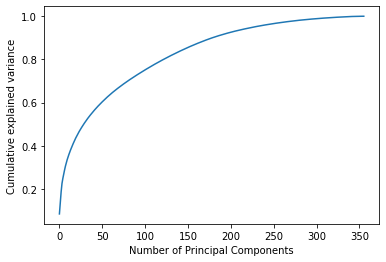

In [128]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative explained variance');

From the plot, I can see that the first 200 principal components explain more than 90% of the variance.
Based on this graph, the number of principal components I want to have depending on the variability it explains.
I will select 200 components for fitting our model.

In [129]:
# Defining PCA with 200 components
pca = PCA(n_components=200)
# Fitting and transformaing PCA on the azdias set
azdias_pca = pca.fit_transform(azdias)

In [130]:
# Printing the shape of azdias sets before and after transformation
print("original shape of azdias: ", azdias.shape)
print("Transformed shape of azdias set:", azdias_pca.shape)


original shape of azdias:  (792027, 356)
Transformed shape of azdias set: (792027, 200)


### General Population Clustering

To define the right number of clusters for a dataset, the so called **Elbow** method will be used.       

In [131]:
# create an empty list called inertia to store our calculated values:
clusters = pd.DataFrame()
clusters['cluster_range'] = range(1, 20)
inertia = []

In [132]:
for k in clusters['cluster_range']:
    kmeans = KMeans(n_clusters=k, random_state=40).fit(azdias_pca)
    inertia.append(kmeans.inertia_)

In [133]:
clusters['inertia'] = inertia
clusters

,cluster_range,inertia
0,1,2.605112e+08
1,2,2.436790e+08
2,3,2.353845e+08
3,4,2.308122e+08
4,5,2.268060e+08
5,6,2.235866e+08
6,7,2.210051e+08
7,8,2.188916e+08
8,9,2.169869e+08
9,10,2.155134e+08


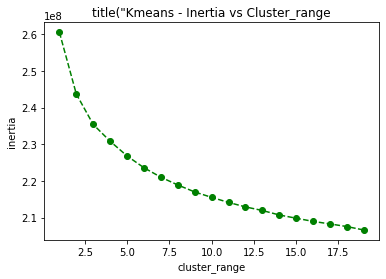

In [134]:
plt.plot(clusters['cluster_range'], clusters['inertia'], linestyle='--', marker='o', color='g');
plt.xlabel('cluster_range');
plt.ylabel('inertia');
plt.title('title("Kmeans - Inertia vs Cluster_range');

Looking at the plot above, the optimal number of clusters have to be chosen such that the intracluster
variation is at a mininum. This can be optimally selected by using the elbow method. 

The elbow method ensures that any additional cluster added to the existing clusters will almost not improve the intra cluster variations. The plot decreases sharply and starts to slow down after cluster number 8. This means the sum of sqaured distances (inertia) between the clusters after cluster number 8 will not change very much.

In [135]:
optim_cluster = 8

kmeans = KMeans(random_state=40, n_clusters=optim_cluster)
kmeans.fit(azdias_pca)

KMeans(random_state=40)

Using the predict method from sklearn, the predicted assigned cluster for each data point is obtained

In [136]:
azdias_clus = kmeans.predict(azdias_pca)

* **PCA and Clustering for general population data, customers**

In [137]:
#transform the scaled customers using pca and 200 number of components

customers_pca = pca.transform(customers)

Using the predict method from sklearn, the predicted assigned cluster for each data point is 
obtained in customers

In [138]:
customers_clus = kmeans.predict(customers_pca)

In [139]:
print(azdias_clus[:20])
print('.....................................')
print(customers_clus[:20])

[4 0 6 3 6 0 0 7 7 2 1 0 2 0 0 7 0 4 0 3]
.....................................
[6 2 6 3 7 1 7 2 1 1 1 1 2 7 1 1 3 6 1 2]


* Find the number of data points in each cluster for each dataset

In [140]:
azdias_clus = pd.Series(azdias_clus)

azdias_clus.value_counts().sort_index()


0    122102
1    127307
2    108324
3     68043
4     95251
5     67586
6    125391
7     78023
dtype: int64

In [141]:
customers_clus = pd.Series(customers_clus)
customers_clus.value_counts().sort_index()

0     1463
1    36314
2    17430
3     4724
4     2596
5     3317
6    39011
7    36048
dtype: int64

### Class comparison between customers and general population (azdias)

In [142]:
# Customer predicted class in a series
c_class = pd.Series(customers_clus).value_counts()

# calculate customer class proportions
prop_customers = pd.DataFrame({'cluster': c_class.index,
                              '% of data': 100*c_class.values/len(customers_clus)})

prop_customers['data'] = 'customers data'
prop_customers

,cluster,% of data,data
0,6,27.686423,customers data
1,1,25.772340,customers data
2,7,25.583557,customers data
3,2,12.370212,customers data
4,3,3.352661,customers data
5,5,2.354102,customers data
6,4,1.842402,customers data
7,0,1.038303,customers data


In [143]:
# general population (azdias) predicted class in a series
az_class = pd.Series(azdias_clus).value_counts()

# calculate general population class proportions
prop_azdias = pd.DataFrame({'cluster': az_class.index,
                              '% of data': 100*az_class.values/len(azdias_clus)})
prop_azdias['data'] = 'general population (azdias)'

prop_azdias

,cluster,% of data,data
0,1,16.073568,general population (azdias)
1,6,15.831657,general population (azdias)
2,0,15.416394,general population (azdias)
3,2,13.676806,general population (azdias)
4,4,12.026231,general population (azdias)
5,7,9.851053,general population (azdias)
6,3,8.590995,general population (azdias)
7,5,8.533295,general population (azdias)


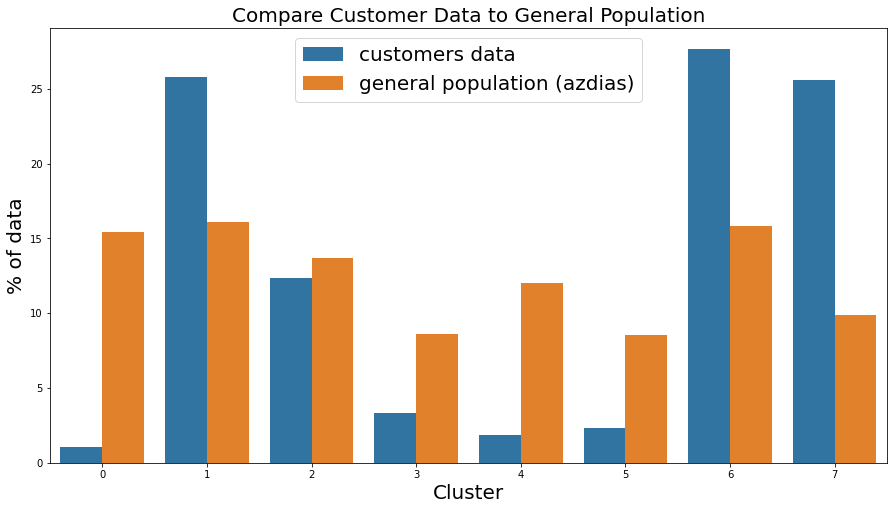

In [144]:
plt.figure(figsize=(15, 8))
sns.barplot(x="cluster", y="% of data", hue="data", 
            data=pd.concat([prop_customers, prop_azdias]))
plt.xlabel('Cluster', fontsize=20)
plt.ylabel('% of data', fontsize=20)
plt.title('Compare Customer Data to General Population', fontsize=20)
plt.legend(fontsize=20)
plt.show()

**Discussion**

Clusters 1, 6 and 7 form over 79 % of customers data and that corresponds to 42 % of  the general population (azdias data). Hence clusters 1, 6 and 7 that forms 42 % of general population are more likely to be part of the mail-order company's main customer base.


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [145]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [146]:
mailout_train = pd.read_csv("Udacity_MAILOUT_052018_TRAIN.csv")

/Users/eamankwah/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [147]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [148]:
mailout_train.shape

(42962, 367)

The mailout_train dataset contains an additional column, RESPONSE compared to the general population datasets.

In [149]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [150]:
mailout_train_obj = mailout_train.select_dtypes(include='object')
mailout_train_obj.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W
1,5B,5,32,D19_TELKO_MOBILE,1997-05-14 00:00:00,W
2,2D,2,14,D19_LEBENSMITTEL,1995-05-24 00:00:00,O
3,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W
4,7B,7,41,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W


The mailout_train data has six categorical columns that has to be recoded or dropped.

* **Checking the reponse balance in the mailout data**

In [151]:
# count the number of rows for each response type
mailout_train.groupby('RESPONSE').size()

RESPONSE
0    42430
1      532
dtype: int64

/Users/eamankwah/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='RESPONSE', ylabel='count'>

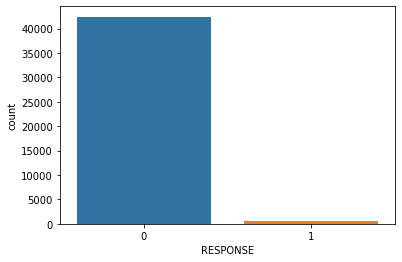

In [152]:
sns.countplot("RESPONSE", data=mailout_train)

The plot gives a hint that the mailout data is hightly imbalanced. Therefore, appropriate metric will
be needed to evaluate the dataset.

In [153]:
# Response percentages

responses_count = mailout_train['RESPONSE'].value_counts(dropna=False)

percent_without_resp = responses_count.values[0] * 100 / len(mailout_train)
percent_with_resp = 100 - percent_without_resp

print('{}% of users without response and {}% users with response'.format(np.round(percent_without_resp,2),
                                                               np.round(percent_with_resp,2)))

98.76% of users without response and 1.24% users with response


### Cleaning Mailout Data

The mailout data will be cleaned before different models will be tried. Following the preprocess of the customer and general 
population, similar steps will be followed. 

In [154]:
def supervised_clean(df, azdias, attributes_values):
    """ 
    Function for feature cleaning, encoding and engineering 
    Input = df
    Output = cleaned df
    """
       
    start = time.time()
         
    # Fill attribute_values dataframe to help find corresponding values information
    attributes_values["Attribute"] = attributes_values["Attribute"].ffill()
    
    # Observing noise columns 18 and 19 with warnings
    noise_column = list(df.columns[18:20])
            
    # Drop missing columns with 30% data missing  
    remove_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4','EXTSEL992','KK_KUNDENTYP']
    df = df.drop(remove_cols, axis = 1)
         
    # Remove features with less information,warnings and too much granularity
    remove_more_cols = ['D19_LETZTER_KAUF_BRANCHE','CAMEO_DEU_2015']
    df = df.drop(remove_more_cols, axis = 1)
        
    # Fix unknown values with nans
    attrib_unknown_values = attributes_values[attributes_values["Meaning"] =="unknown"]
    df = unknowns_rep(df, attrib_unknown_values)
        
    # Fix CAMEO_DEUG_2015 and CAMEO_INTL_2015 attributes
    df = cameo_rep(df)
        
    # Fix eigefugt feature
    df = eigefugt_distr(df)
        
    # Wohnlage column encoding
    df = wohnlage_rep(df)
       
    # Drop and encode lp columns
    df = lp_rep(df)
       
    # Encode Cameo_intl-2015
    
    # df data
    df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].apply(lambda x: float(x))
    df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].apply(cameo_intl_rep)

    # CAMEO_INTL_2015 Wealth Levels and CAMEO_INTL_2015 Age Stages
    df["CAMEO_INTL_2015_wlevels"] = df["CAMEO_INTL_2015"].apply(lambda x: x[0])
    df["CAMEO_INTL_2015_astages"] = df["CAMEO_INTL_2015"].apply(lambda x: x[1])

    # drop CAMEO_INTL_2015
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # Encod Anrede feature
    df = anrede_rep(df)
   
    # Label encode ost_west feature
    df = ost_west_rep(df)
    
    # drop identity, LNR columns
    df = df.drop("LNR", axis=1)
 
    # Imputing Missing data
    imp = SimpleImputer(strategy="most_frequent")

    df = pd.DataFrame(imp.fit_transform(df), columns = df.columns)
        
    end = time.time()
    
    print(f"Cleaed successfully in {end-start} seconds")
    
    return df

In [155]:
mailout_train_LNR = mailout_train["LNR"]

In [156]:
mailout_train_clean = supervised_clean(mailout_train, azdias, attributes_values)

Cleaed successfully in 8.177962064743042 seconds


In [157]:
# Checking object data types that may have not been removed
mailout_train_clean.select_dtypes(include='object').sum().sum()

0.0

In [158]:
# Cheking for number of missing values in dataset
mailout_train_clean.isnull().sum().sum()

0

In [159]:
target = mailout_train_clean["RESPONSE"]

In [160]:
#drop target column from feature columns
mailout_train_clean = mailout_train_clean.drop("RESPONSE", axis=1)

In [161]:
print(mailout_train_clean.shape)
print("............")
print(azdias.shape)

(42962, 356)
............
(792027, 356)


In [162]:
print(target.shape)

(42962,)


### Baseline Model

In [163]:
scaler = StandardScaler()
mailout_train_clean_ss = pd.DataFrame(scaler.fit_transform(mailout_train_clean),
                                      columns=mailout_train_clean.columns)

In [164]:
# creat copies of feature set and target set as X and Y, respectively

X = mailout_train_clean_ss.copy()
Y = target.copy()

In this baseline model a logistic regression will be used without balancing or scalling the dataset

In [166]:
# train-test-slit function
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=40)
# Defining the LogisticRegression function
lr_model = LogisticRegression(max_iter=10000)

In [167]:
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [168]:
pred = lr_model.predict(X_test)
print('Accuracy of Logistic regression model prediction on test set: {:.2f}'.format(lr_model.score(X_test, y_test)))

Accuracy of Logistic regression model prediction on test set: 0.99


In [169]:
# Confusion Matrix for the model

confusionMatrix = confusion_matrix(y_test, pred)
print(confusionMatrix)

# classification report
print(classification_report(y_test, pred))

[[12736     2]
 [  151     0]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     12738
         1.0       0.00      0.00      0.00       151

    accuracy                           0.99     12889
   macro avg       0.49      0.50      0.50     12889
weighted avg       0.98      0.99      0.98     12889



In [170]:
print('Percentage of positive class :',(y_train[y_train== 1].value_counts()/len(y_train) ) * 100)
print('Percentage of negative class :',(y_train[y_train== 0].value_counts()/len(y_train) ) * 100)

Percentage of positive class : 1.0    1.266917
Name: RESPONSE, dtype: float64
Percentage of negative class : 0.0    98.733083
Name: RESPONSE, dtype: float64


In [171]:
# auc score
y_proba = lr_model.predict_proba(X_test)
_auc = roc_auc_score(y_test, y_proba[:, 0])

In [172]:
print("Baseline AUC : ",_auc)

Baseline AUC :  0.3438371811308709


An accuracy of 99% was excellent but the recall, positive response was  0, very very poor. From the metrics,
we can see that the number of values for No(0) is perfect but for YES(1) is absolute zero. The classifier is therefore biased towards the negative response.

Since the data is imbalance, I will try to balance the data and see how the recall improves.

###  **Balancing the data**

#### Undersampling Method.

In [173]:
X = X.copy()
Y = Y.copy()

In [174]:
# scale X dataset
minmaxScaler = MinMaxScaler()
X = pd.DataFrame(minmaxScaler.fit_transform(X.values),columns=X.columns)

In [175]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=40)


In [176]:
# let us first join the train_x and train_y for ease of operation
trainData = pd.concat([X_train,y_train],axis=1)
trainData.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_family,LP_income,LP_age_stages,LP_wealth_levels,CAMEO_INTL_2015_wlevels,CAMEO_INTL_2015_astages,RESPONSE
41353,0.666667,0.0,0.666667,0.56,0.123288,0.05,0.0,0.125000,0.149051,0.0,...,0.4,0.0,0.250,0.25,0.00,0.666667,0.000000,0.75,1.00,0.0
37368,0.666667,0.0,0.476190,0.40,0.002283,0.00,0.0,0.083333,0.002710,0.0,...,0.4,1.0,0.250,0.25,1.00,0.666667,1.000000,0.00,0.75,0.0
19446,0.333333,0.0,0.000000,0.24,0.002283,0.00,0.0,0.166667,0.002710,0.0,...,0.4,0.0,0.375,1.00,0.75,1.000000,0.333333,0.25,0.75,0.0
39904,0.666667,0.0,0.000000,0.36,0.002283,0.00,0.0,0.041667,0.002710,0.0,...,0.4,1.0,0.000,1.00,1.00,1.000000,1.000000,0.25,0.75,0.0
12587,0.666667,0.0,0.000000,0.00,0.009132,0.00,0.0,0.041667,0.008130,0.0,...,0.4,0.0,0.375,0.00,0.00,1.000000,0.000000,0.75,0.75,0.0


In [177]:
# Finding the indexes of the sample data set where the responses is 1
ind = trainData[trainData['RESPONSE']==1].index
print(len(ind))

381


In [178]:
# Seperate the minority classes
minData = trainData.loc[ind]
print(minData.shape)

(381, 357)


In [179]:
# Finding indexes of majority class
ind1 = trainData[trainData['RESPONSE']==0].index

In [180]:
print(len(ind1))

29692


In [181]:
# Seperating the majority class
majData = trainData.loc[ind1]
print(majData.shape)
majData.head()

(29692, 357)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_family,LP_income,LP_age_stages,LP_wealth_levels,CAMEO_INTL_2015_wlevels,CAMEO_INTL_2015_astages,RESPONSE
41353,0.666667,0.0,0.666667,0.56,0.123288,0.05,0.0,0.125000,0.149051,0.0,...,0.4,0.0,0.250,0.25,0.00,0.666667,0.000000,0.75,1.00,0.0
37368,0.666667,0.0,0.476190,0.40,0.002283,0.00,0.0,0.083333,0.002710,0.0,...,0.4,1.0,0.250,0.25,1.00,0.666667,1.000000,0.00,0.75,0.0
19446,0.333333,0.0,0.000000,0.24,0.002283,0.00,0.0,0.166667,0.002710,0.0,...,0.4,0.0,0.375,1.00,0.75,1.000000,0.333333,0.25,0.75,0.0
39904,0.666667,0.0,0.000000,0.36,0.002283,0.00,0.0,0.041667,0.002710,0.0,...,0.4,1.0,0.000,1.00,1.00,1.000000,1.000000,0.25,0.75,0.0
12587,0.666667,0.0,0.000000,0.00,0.009132,0.00,0.0,0.041667,0.008130,0.0,...,0.4,0.0,0.375,0.00,0.00,1.000000,0.000000,0.75,0.75,0.0


In [182]:
# Take a random sample equal to length of the minority class to make the dataset balanced
majSample = majData.sample(n=len(ind),random_state = 40)
print(majSample.shape)
majSample.head()

(381, 357)


,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,LP_family,LP_income,LP_age_stages,LP_wealth_levels,CAMEO_INTL_2015_wlevels,CAMEO_INTL_2015_astages,RESPONSE
42722,0.666667,0.0,0.000000,0.36,0.002283,0.0,0.333333,0.166667,0.00271,0.0,...,0.6,1.0,0.375,1.00,0.75,1.000000,0.333333,0.75,0.00,0.0
29913,0.333333,0.0,0.904762,0.48,0.002283,0.0,0.000000,0.166667,0.00271,0.0,...,0.4,1.0,0.375,1.00,1.00,1.000000,1.000000,0.75,0.00,0.0
30720,0.666667,0.0,0.714286,0.60,0.004566,0.0,0.000000,0.041667,0.00542,0.0,...,0.0,0.0,0.125,0.00,0.75,0.666667,0.333333,0.25,0.75,0.0
34438,0.666667,0.0,0.380952,0.00,0.002283,0.0,0.000000,0.083333,0.00271,0.0,...,0.0,0.0,0.375,0.25,1.00,0.666667,1.000000,0.00,0.75,0.0
32409,0.333333,0.0,0.619048,0.48,0.002283,0.0,0.000000,0.083333,0.00271,0.0,...,0.0,0.0,0.375,0.25,1.00,0.666667,1.000000,0.25,0.75,0.0


In [183]:
# Concatenating both data sets
balData = pd.concat([minData,majSample],axis = 0)
print('balanced data set shape',balData.shape)

balanced data set shape (762, 357)


In [184]:
# Shuffling the data set

balData = shuffle(balData)

In [185]:
# Making the new X_train and y_train
X_trainNew = balData.iloc[:,0:356]
X_trainNew.shape

(762, 356)

In [186]:
# Making the new y_train
y_trainNew = balData['RESPONSE']
y_trainNew.shape

(762,)

In [187]:
# Defining the LogisticRegression function for Undersampling

lrModel1 = LogisticRegression(max_iter=10000)
lrModel1.fit(X_trainNew, y_trainNew)

LogisticRegression(max_iter=10000)

#### SMOTE

In [188]:
# Instantiating the SMOTE class
oversampler= sv.SMOTE()

In [189]:
# Creating new training set

X_train_smote, y_train_smote = oversampler.sample(np.array(X_train), np.array(y_train))

2020-10-28 11:07:10,705:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


In [190]:
# Training the model with Logistic regression model

# Defining the LogisticRegression function

lrModel2 = LogisticRegression(max_iter=10000)

lrModel2.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=10000)

#### MSMOTE

In [191]:
# Instantiating the MSMOTE class
oversampler= sv.MSMOTE()

In [192]:
# Creating new training sets
X_train_msmote, y_train_msmote = oversampler.sample(np.array(X_train), np.array(y_train))

2020-10-28 11:08:03,409:INFO:MSMOTE: Running sampling via ('MSMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


In [193]:
%%time
# Fitting model

# Training the model with Logistic regression model

# Defining the LogisticRegression function
lrModel3 = LogisticRegression(max_iter=10000)
lrModel3.fit(X_train_msmote, y_train_msmote)

CPU times: user 1min 29s, sys: 1.57 s, total: 1min 30s
Wall time: 24.6 s


LogisticRegression(max_iter=10000)

**Predictions with all three models**

Let us create separate predictions with each model

In [194]:
# Printing accuracy of each model

print('Accuracy of Logistic regression model prediction on test set for Random Undersampled data set: {:.2f}'.format(lrModel1.score(X_test, y_test)))

print('Accuracy of Logistic regression model prediction on test set for SMOTE data set: {:.2f}'.format(lrModel2.score(X_test, y_test)))

print('Accuracy of Logistic regression model prediction on test set for MSMOTE data set: {:.2f}'.format(lrModel3.score(X_test, y_test)))

Accuracy of Logistic regression model prediction on test set for Random Undersampled data set: 0.64
Accuracy of Logistic regression model prediction on test set for SMOTE data set: 0.80
Accuracy of Logistic regression model prediction on test set for MSMOTE data set: 0.96


Since the date set is balanced for both positive and negative response classes, accuracy could be used as a metric. However, the balancing techniques has decreased the accuracy values from 99% to a minimum of 64% for the undersampling techniques

In [195]:
# Predicting using Under sampler
pred_us = lrModel1.predict(X_test)

# Predicting using SMOTE
pred_smote = lrModel2.predict(X_test)

# Predicting using MSMOTE
pred_msmote = lrModel3.predict(X_test)


In [196]:
# Metrics for Random undersample data set
print(confusion_matrix(y_test, pred_us))

print(classification_report(y_test, pred_us))

[[8213 4525]
 [  71   80]]
              precision    recall  f1-score   support

         0.0       0.99      0.64      0.78     12738
         1.0       0.02      0.53      0.03       151

    accuracy                           0.64     12889
   macro avg       0.50      0.59      0.41     12889
weighted avg       0.98      0.64      0.77     12889



In [197]:
# Metrics for SMOTE data set
print(confusion_matrix(y_test, pred_smote))

print(classification_report(y_test, pred_smote))

[[10248  2490]
 [  101    50]]
              precision    recall  f1-score   support

         0.0       0.99      0.80      0.89     12738
         1.0       0.02      0.33      0.04       151

    accuracy                           0.80     12889
   macro avg       0.50      0.57      0.46     12889
weighted avg       0.98      0.80      0.88     12889



In [198]:
# Metrics for MSMOTE data set
print(confusion_matrix(y_test, pred_msmote))

print(classification_report(y_test, pred_msmote))

[[12389   349]
 [  140    11]]
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     12738
         1.0       0.03      0.07      0.04       151

    accuracy                           0.96     12889
   macro avg       0.51      0.52      0.51     12889
weighted avg       0.98      0.96      0.97     12889



In [199]:
# auc score
y_proba1 = lrModel1.predict_proba(X_test)
_auc = roc_auc_score(y_test, y_proba1[:, 0])
print("Udersampling AUC : ",_auc)

Udersampling AUC :  0.3638835772195413


In [200]:
# auc score
y_proba2 = lrModel2.predict_proba(X_test)
_auc = roc_auc_score(y_test, y_proba2[:, 0])
print("SMOTE AUC : ",_auc)

SMOTE AUC :  0.33562168367267364


In [201]:
# auc score
y_proba3 = lrModel3.predict_proba(X_test)
_auc = roc_auc_score(y_test, y_proba3[:, 0])
print("MSMOTE AUC : ",_auc)

MSMOTE AUC :  0.3646109206535382


The above sampling techniques did improve the model over the baseline. However, all the models are still under performing considering the low recall and AUC results. The AUC measures the probability of correctly distinquishing between a positive class from a negative class. Hence the higher the AUC the better the performance of th model.

Other algorithms will therefore be used to try to improve on the AUC results

## Modelling with Full Data and PCA Reduced Data

In [202]:
# Scale clean mailout data
scaler = StandardScaler()
mailout_train_clean_ss2 = pd.DataFrame(scaler.fit_transform(mailout_train_clean),
                                       columns = mailout_train_clean.columns)

In [203]:
X_train, X_val, y_train, y_val = train_test_split(mailout_train_clean_ss2, target, stratify=target,
                                                  test_size=0.3, random_state=40)

In [204]:
def train_score(model, X_train, y_train, X_test, y_test):
    """
    Fit, predict and score model
    Outputs - AUC score
    """

    model = model.fit(X_train, y_train)
    auc_score_train = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
   
    return auc_score_train

In [205]:
models = [("svc", SVC(probability=True, random_state=40)),
("rf", RandomForestClassifier(random_state=40)),
("gb", GradientBoostingClassifier(random_state=40)),
("ab", AdaBoostClassifier(random_state=40)),
("xgb",xgb.XGBClassifier(random_state=40))]

In [206]:
%%time
output = {"Model":[],"AUC_Score":[]}
for i, model in models:
    score = train_score(model, X_train, y_train, X_val, y_val)
    output["Model"].append(i)
    output["AUC_Score"].append(score)
output = pd.DataFrame.from_dict(output, orient='index').transpose()
output

CPU times: user 25min 32s, sys: 8.34 s, total: 25min 40s
Wall time: 24min 48s


,Model,AUC_Score
0,svc,0.588582
1,rf,0.612408
2,gb,0.741031
3,ab,0.7141
4,xgb,0.649038


* **Modelling with PCA (reduce) Dataset**

In [207]:
mailout_train_pca = pca.transform(mailout_train_clean_ss2)
X_train_p, X_val_p, y_train_p, y_val_p = train_test_split(mailout_train_pca,
                                                          target,stratify=target, test_size=0.3, random_state=40)

In [208]:
%%time
models = [("svc", SVC(probability=True, random_state=40)),
("rf", RandomForestClassifier(random_state=40)),
("gb", GradientBoostingClassifier(random_state=40)),
("ab", AdaBoostClassifier(random_state=40)),
("xgb",xgb.XGBClassifier(random_state=40))]

output_p = {"Model":[],"AUC_Score":[]}
for i, model in models:
    score = train_score(model, X_train_p, y_train_p, X_val_p, y_val_p)
    output_p["Model"].append(i)
    output_p["AUC_Score"].append(score)
output_p = pd.DataFrame.from_dict(output_p, orient='index').transpose()
output_p



CPU times: user 21min 4s, sys: 5.02 s, total: 21min 9s
Wall time: 19min 46s


,Model,AUC_Score
0,svc,0.575387
1,rf,0.475882
2,gb,0.540325
3,ab,0.554217
4,xgb,0.556427


* **Plot AUC For Full Feaature Dimension and Reduced Feature Dimension**

In [209]:
df = pd.DataFrame({'Classifier': ['SVC', 'RF', 'GB', 'AB', 'XGB'],
                'Train-Full Dimension': [0.5898,0.6124,0.7410, 0.7141, 0.6490],
               'Train-Reduced-Dimension': [0.5754, 0.4759, 0.6403, 0.5542, 0.5564]})

df

,Classifier,Train-Full Dimension,Train-Reduced-Dimension
0,SVC,0.5898,0.5754
1,RF,0.6124,0.4759
2,GB,0.7410,0.6403
3,AB,0.7141,0.5542
4,XGB,0.6490,0.5564


<AxesSubplot:xlabel='Classifier'>

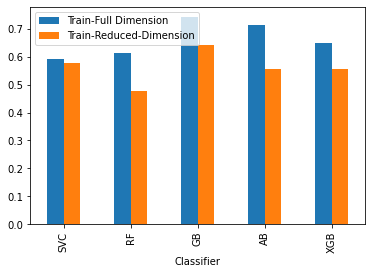

In [210]:
df.plot(kind='bar', x = 'Classifier', legend=True)

The models using the full dataset are doing better than the pca reduced dataset models.Tuning models in general takea alot of time and hence the top three models, GradientBoostingClassifier, AdaBoostClassifierdaboast and 
XGBClassifier would be further analysed to tuned the model for a higher performance.

### Random Search Hyperparameter Tuning for Gradient Boosting Classifier

In [211]:
from sklearn.metrics import make_scorer, roc_auc_score

auc_scoring = make_scorer(roc_auc_score)

In [212]:
# random grid
random_grid_gb = {'n_estimators': range(100, 500, 100), # number of trees
               'max_depth':range(2,20,2),  # maximum depth of the tree
               'learning_rate':[0.001,0.01,0.05,0.1]} # criterion for evaluating a split

print(random_grid_gb)

{'n_estimators': range(100, 500, 100), 'max_depth': range(2, 20, 2), 'learning_rate': [0.001, 0.01, 0.05, 0.1]}


In [213]:
# create the randomized search cross validation
gb_random = RandomizedSearchCV(estimator = GradientBoostingClassifier(random_state=40), 
                               param_distributions = random_grid_gb,
                               n_iter = 25, cv = 3, scoring = auc_scoring, n_jobs=-1,
                               verbose = 0, random_state = 40)

In [214]:
%%time

# fit the random search model

gb_random.fit(X_train, y_train)

best_gb = gb_random.best_estimator_
# Best estimate
print("Best Params: ", gb_random.best_params_)

Best Params:  {'n_estimators': 200, 'max_depth': 18, 'learning_rate': 0.05}
CPU times: user 8min 22s, sys: 1.45 s, total: 8min 24s
Wall time: 2h 5min 46s


In [215]:
pred_gb = gb_random.predict_proba(X_val)[:,1]
print("AUC score on validation data: {:.4f}".format(roc_auc_score(y_val, pred_gb)))

AUC score on validation data: 0.6750


### Random Search Hyperparameter Tuning for Adaboost Classifier

In [216]:
# random grid
random_grid_ab = {'n_estimators': range(100, 500, 100), # number of trees
               'algorithm':["SAMME.R"],  # algorithm
               'learning_rate':[0.001,0.01,0.05, 0.1]} # criterion for evaluating a split

print(random_grid_ab)

{'n_estimators': range(100, 500, 100), 'algorithm': ['SAMME.R'], 'learning_rate': [0.001, 0.01, 0.05, 0.1]}


In [217]:
# create the randomized search cross validation
ab_random = RandomizedSearchCV(estimator = AdaBoostClassifier(random_state=40), 
                               param_distributions = random_grid_ab,
                               scoring = auc_scoring,
                               verbose=0, cv=3,n_jobs=-1,
                               random_state = 40)

In [218]:
%%time

# fit the random search model

ab_random.fit(X_train, y_train)
best_ab1 = ab_random.best_estimator_
# Best estimate
print("Best Params: ", ab_random.best_params_)

Best Params:  {'n_estimators': 200, 'learning_rate': 0.1, 'algorithm': 'SAMME.R'}
CPU times: user 40.9 s, sys: 2.02 s, total: 42.9 s
Wall time: 7min 55s


In [219]:
pred_ab1 = ab_random.predict_proba(X_val)[:,1]
print("AUC score on validation data: {:.4f}".format(roc_auc_score(y_val, pred_ab1)))

AUC score on validation data: 0.7491


In [220]:
# ab 25
# random grid
random_grid_ab2 = {'n_estimators': range(100, 500, 50), # number of trees
               'algorithm':["SAMME.R"],  # algorithm
               'learning_rate':[0.05,0.07,0.085, 1.0]} # criterion for evaluating a split

print(random_grid_ab2)

{'n_estimators': range(100, 500, 50), 'algorithm': ['SAMME.R'], 'learning_rate': [0.05, 0.07, 0.085, 1.0]}


In [222]:
# create the randomized search cross validation
ab_random2 = RandomizedSearchCV(estimator = AdaBoostClassifier(random_state=40), 
                               param_distributions = random_grid_ab2,
                               scoring = auc_scoring,
                               verbose=0, cv=5,n_jobs=-1,
                               random_state = 40)

In [223]:
%%time

# fit the random search model

ab_random2.fit(X_train, y_train)
best_ab2 = ab_random2.best_estimator_
# Best estimate
print("Best Params: ", ab_random2.best_params_)

Best Params:  {'n_estimators': 450, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}
CPU times: user 1min 31s, sys: 4.14 s, total: 1min 35s
Wall time: 18min 35s


In [225]:
pred_ab2 = ab_random2.predict_proba(X_val)[:,1]
print("AUC score on validation data: {:.4f}".format(roc_auc_score(y_val, pred_ab2)))

AUC score on validation data: 0.6637


###  Random Search Hyperparameter Tuning for XGBoost Classifier

In [226]:
# random grid
random_grid_xgb = {'n_estimators': range(100, 500, 50), # number of trees
                  'max_depth':range(2,10,2),  # maximum depth of the tree
                  'gamma':[0.25,0.5,0.75,1.0], 
               'learning_rate':[0.01,0.1,0.25,0.5]} # criterion for evaluating a split

print(random_grid_xgb)

{'n_estimators': range(100, 500, 50), 'max_depth': range(2, 10, 2), 'gamma': [0.25, 0.5, 0.75, 1.0], 'learning_rate': [0.01, 0.1, 0.25, 0.5]}


In [227]:
# create the randomized search cross validation
xgb_random = RandomizedSearchCV(estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                                              random_state = 40, silent=1),
                               param_distributions = random_grid_xgb,
                               scoring = auc_scoring,
                               verbose=2, cv=5,n_iter = 50,
                               n_jobs=-1)

In [228]:
%%time

# fit the random search model

xgb_random.fit(X_train, y_train)
best_xgb = xgb_random.best_estimator_
# Best estimate
print("Best Params: ", xgb_random.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 88.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 147.1min finished


Best Params:  {'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.5, 'gamma': 0.75}
CPU times: user 4min 27s, sys: 2.49 s, total: 4min 29s
Wall time: 2h 28min 21s


In [229]:
pred_xgb = xgb_random.predict_proba(X_val)[:,1]
print("AUC score on validation data: {:.4f}".format(roc_auc_score(y_val, pred_xgb)))

AUC score on validation data: 0.6560


## Automated Hyperparameter Tuning with Hyperopt

In [230]:
# installing hpsklearn
#!pip install hpsklearn

### Automated Search Hyperparameter Tuning for Gradient Boosting Classifier

In [231]:
# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 500, 100),
       'max_depth' : hp.quniform('max_depth', 5, 25, 5),
       'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
      }


In [232]:
def objective(params):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'learning_rate': params['learning_rate']}
    
    # we use this params to create a new gb classifier
    shuffle = KFold(n_splits=5, shuffle=True)
    model_gb = GradientBoostingClassifier(random_state=40, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = cross_val_score(model_gb, X_train, y_train, cv=shuffle, scoring='roc_auc', n_jobs=1)

    return 1 - score.mean()

In [233]:
%%time
# The Trials object will store details of each iteration
trials = Trials()

# Run the hyperparameter search using the tpe algorithm
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=2,
            trials=trials)

100%|██████████| 2/2 [2:03:09<00:00, 3694.89s/trial, best loss: 0.33792267206259696]  
CPU times: user 2h 2min 21s, sys: 15.3 s, total: 2h 2min 36s
Wall time: 2h 3min 10s


In [234]:
# Print best parameters
best_params = space_eval(space, best)
best_params

{'learning_rate': 0.06556506226654961,
 'max_depth': 20.0,
 'n_estimators': 400.0}

In [235]:
# Get the values of the optimal parameters
# computing the score on the test set

model_hgb = GradientBoostingClassifier(n_estimators=400,
                                  max_depth = 20,
                                  learning_rate = 0.06556,
                                  random_state=40)
# Fit the model with the optimal hyperparamters
model_hgb.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.06556, max_depth=20,
                           n_estimators=400, random_state=40)

In [237]:
pred_hgb = model_hgb.predict_proba(X_val)[:,1]
print("Automated Tuned AUC score on validation data: {:.4f}".format(roc_auc_score(y_val, pred_hgb)))


Automated Tuned AUC score on validation data: 0.6602


### Automated Search Hyperparameter Tuning for Ada (AB-5) Boosting Classifier

In [239]:
# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
       'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)}

In [240]:
def objective(params):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']), 
              'learning_rate': params['learning_rate']}
    
    # we use this params to create a new gb classifier
    shuffle = KFold(n_splits=5, shuffle=True)
    model_ab1 = AdaBoostClassifier(random_state=40, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = cross_val_score(model_ab1, X_train, y_train, cv=shuffle, scoring='roc_auc', n_jobs=1)

    return 1 - score.mean()

In [241]:
%%time
# The Trials object will store details of each iteration
trials = Trials()

# Run the hyperparameter search using the tpe algorithm
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=5,
            trials=trials)

100%|██████████| 5/5 [28:34<00:00, 342.83s/trial, best loss: 0.2404330659792595] 
CPU times: user 26min 28s, sys: 1min 20s, total: 27min 48s
Wall time: 28min 34s


In [242]:
# Print best parameters
best_params = space_eval(space, best)
best_params

{'learning_rate': 0.01816069089537726, 'n_estimators': 450.0}

In [243]:
model_hab1 = AdaBoostClassifier(n_estimators=450,
                           algorithm = "SAMME.R",
                           learning_rate = 0.01816,
                           random_state=40)
# Fit the model with the optimal hyperparamters
model_hab1.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.01816, n_estimators=450, random_state=40)

In [245]:
pred_hab1 = model_hab1.predict_proba(X_val)[:,1]
print("Automated Tuned AUC score on validation data: {:.4f}".format(roc_auc_score(y_val, pred_hab1)))


Automated Tuned AUC score on validation data: 0.7508


###  Automated Search Hyperparameter Tuning for XGBoost Classifier

In [246]:
# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
       'max_depth' : hp.quniform('max_depth', 2, 20, 2),
       'gamma': hp.uniform('gamma', 0.01, .7),
       'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
      }

In [247]:
def objective(params):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth' : int(params['max_depth']),
              'gamma' : params['gamma'],
              'learning_rate': params['learning_rate']}
    
    # we use this params to create a new gb classifier
    shuffle = KFold(n_splits=5, shuffle=True)
    model_hxgb = xgb.XGBClassifier(random_state=40, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = cross_val_score(model_hxgb, X_train, y_train, cv=shuffle, scoring='roc_auc', n_jobs=1)

    return 1 - score.mean()

In [248]:
%%time
# The Trials object will store details of each iteration
trials = Trials()

# Run the hyperparameter search using the tpe algorithm
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)

100%|██████████| 10/10 [1:33:06<00:00, 558.66s/trial, best loss: 0.24921021270031807]
CPU times: user 5h 34min 32s, sys: 2min 34s, total: 5h 37min 7s
Wall time: 1h 33min 6s


In [249]:
# Print best parameters
best_params = space_eval(space, best)
best_params

{'gamma': 0.08545531121534325,
 'learning_rate': 0.04082249888414267,
 'max_depth': 4.0,
 'n_estimators': 300.0}

In [250]:
%%time
# computing the score on the test set

model_hxgb = xgb.XGBClassifier(n_estimators=300,
                          max_depth = 4,
                          gamma = 0.085455,
                          learning_rate = 0.04082,
                          random_state=40)
# Fit the model with the optimal hyperparamters
model_hxgb.fit(X_train, y_train)

CPU times: user 3min 8s, sys: 833 ms, total: 3min 9s
Wall time: 49.9 s


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.085455, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.04082, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=40,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [251]:
pred_hxgb = model_hxgb.predict_proba(X_val)[:,1]
print("Automated Tuned AUC score on validation data: {:.4f}".format(roc_auc_score(y_val, pred_hxgb)))

Automated Tuned AUC score on validation data: 0.7368


###  Automated Search Hyperparameter Tuning for Ada (AB-25) Boosting Classifier

In [252]:
# possible values of parameters
space={'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
       'learning_rate': hp.loguniform('learning_rate', -3, 0)}

In [254]:
def objective(params):
    # the function gets a set of variable parameters in "param"
    params = {'n_estimators': int(params['n_estimators']),
              'learning_rate': params['learning_rate']}
    
    # we use this params to create a new gb classifier
    shuffle = KFold(n_splits=5, shuffle=True)
    model_ab2 = AdaBoostClassifier(random_state=40, **params)
    
    # and then conduct the cross validation with the same folds as before
    score = cross_val_score(model_ab2, X_train, y_train, cv=shuffle, scoring='roc_auc', n_jobs=1)

    return 1 - score.mean()

In [255]:
%%time
# The Trials object will store details of each iteration
trials = Trials()

# Run the hyperparameter search using the tpe algorithm
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=25,
            trials=trials)

100%|██████████| 25/25 [1:35:05<00:00, 228.22s/trial, best loss: 0.23628509941950204]
CPU times: user 1h 29min 35s, sys: 5min 4s, total: 1h 34min 39s
Wall time: 1h 35min 5s


In [256]:
# Print best parameters
best_params = space_eval(space, best)
best_params

{'learning_rate': 0.05189729881211738, 'n_estimators': 100.0}

In [257]:
# computing the score on the test set
#model = AdaBoostClassifier(**best_params)

model_hab2 = AdaBoostClassifier(n_estimators=100,
                           algorithm = "SAMME.R",
                           learning_rate = 0.051897,
                           random_state=40)
# Fit the model with the optimal hyperparamters
model_hab2.fit(X_train, y_train)


AdaBoostClassifier(learning_rate=0.051897, n_estimators=100, random_state=40)

In [259]:
pred_hab2 = model_hab2.predict_proba(X_val)[:,1]
print("Automated Tuned AUC score on validation data: {:.4f}".format(roc_auc_score(y_val, pred_hab2)))


Automated Tuned AUC score on validation data: 0.7538


### Random Search Vs Automated Tuning Results

In [260]:
df = pd.DataFrame({'Classifier': ['GB', 'AB-5','AB-25', 'XGB'],
                'Random Search Optimization (RS)': [0.6750, 0.7491, 0.6837, 0.6560],
                 'RSearch Time (min)': [125, 8, 18.5, 148],  
               'Automated Tuning': [0.6602, 0.7508, 0.7538, 0.7368],
                'ATuning Time (min)': [123, 28.5, 95, 93],                
                  })

df

,Classifier,Random Search Optimization (RS),RSearch Time (min),Automated Tuning,ATuning Time (min)
0,GB,0.6750,125.0,0.6602,123.0
1,AB-5,0.7491,8.0,0.7508,28.5
2,AB-25,0.6837,18.5,0.7538,95.0
3,XGB,0.6560,148.0,0.7368,93.0


The above results indicate the following :
* random search optimization for gradient boosting was higher than corresponding automated tuning.
* aumated tuning for ada boosting (AB-5 and AB-25) and xgb were higher that thier corresponding random search optimization.
* with the exception of random search time for ada boosting algorithms(AB-5 and AB-25), the automated tuning times were lower than the correspond random search optimizations.
* the highest performing algorithm is ada boosting algorith, AB-25 with automated tuning and recorded AUC of 0.7538.

### Comparing Best Models with and without Hyperparameter Tuning

In [261]:
df1 = pd.DataFrame({'Classifier': ['GB', 'AB', 'XGB'],
                   'Train-Full Dimension': [0.7410, 0.7141, 0.6490],
                'Random Search Optimized': [0.6750, 0.7491, 0.65602],
                 'Automated Tuning': [0.6602, 0.7538, 0.7368],
                  })

df1

,Classifier,Train-Full Dimension,Random Search Optimized,Automated Tuning
0,GB,0.7410,0.67500,0.6602
1,AB,0.7141,0.74910,0.7538
2,XGB,0.6490,0.65602,0.7368


<AxesSubplot:xlabel='Classifier'>

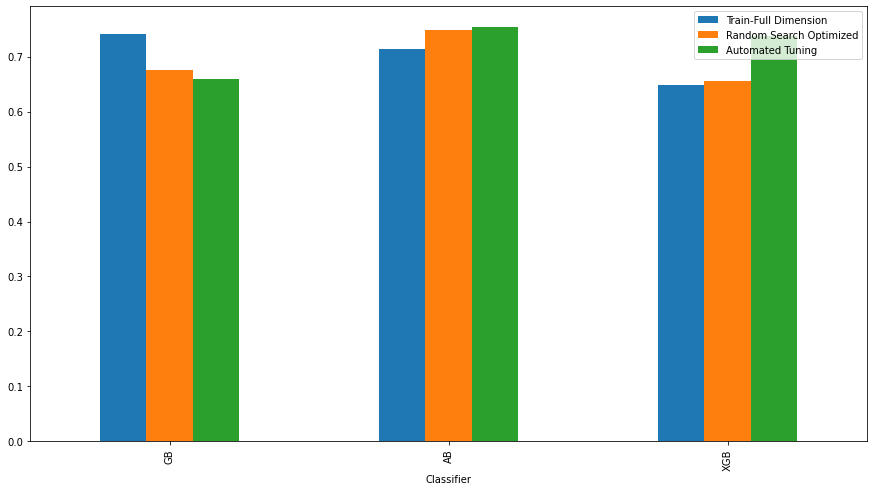

In [262]:
df1.plot(kind='bar', x = 'Classifier', figsize=(15,8), legend=True)

The plots above indicate the following:
* in general, tuned or optimized models performs better than untuned models.
* The best performing model; automated ada boost and xgb will be further processed for submission.
    

#### Automated adaboost: Feature Importance for Top Ten Features 

In [263]:
feature_importances = pd.Series(model_hab2.feature_importances_,
                                  index = mailout_train_clean.columns).sort_values(ascending = False)

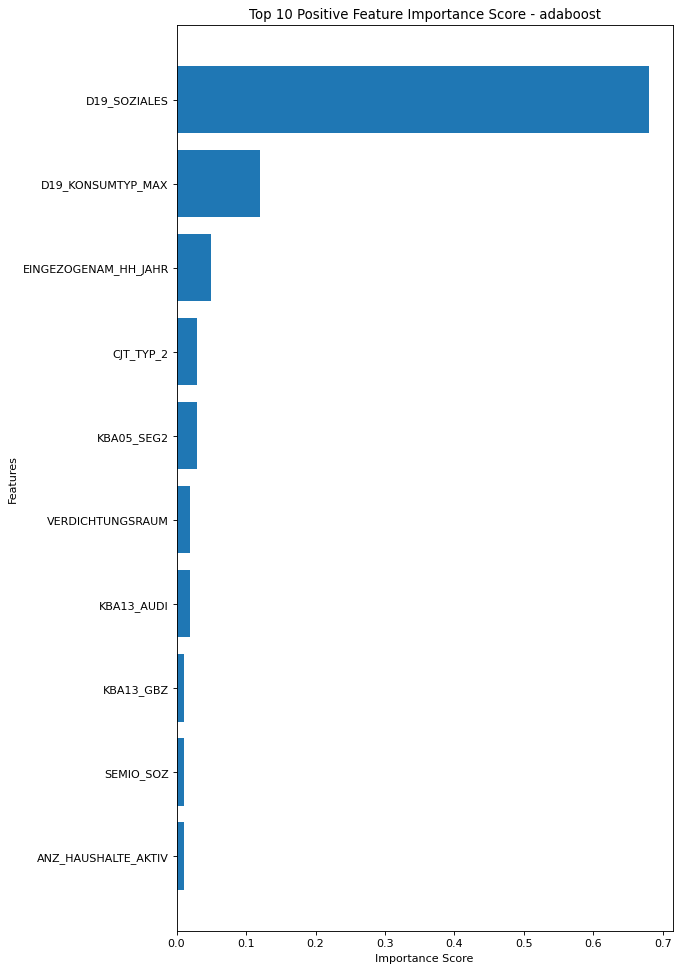

In [266]:
num_imp = 10
ylocs = np.arange(num_imp)
# get the feature importance for top num and sort in reverse order
val_imp_plot = feature_importances.iloc[:num_imp].values.ravel()[::-1]
feat_imp__labels = list(feature_importances.iloc[:num_imp].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, val_imp_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Top 10 Positive Feature Importance Score - adaboost')
plt.yticks(ylocs, feat_imp__labels)
plt.show()

####  Automated Tuned xgboost: Feature Importance for Top Ten Features

In [274]:
feature_importances = pd.Series(model_hxgb.feature_importances_,
                                  index = mailout_train_clean.columns).sort_values(ascending = False)

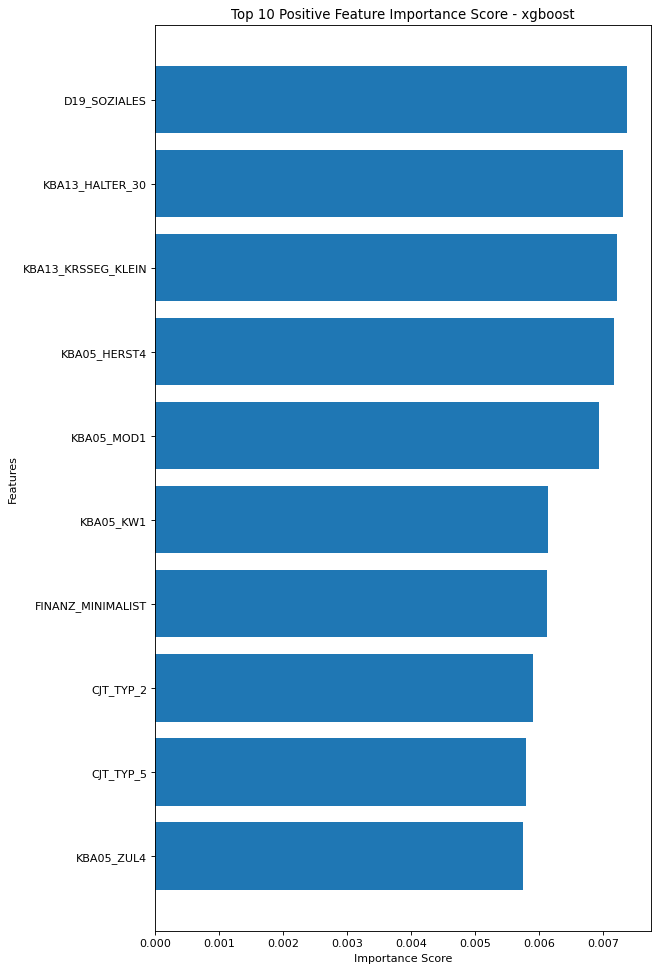

In [276]:
num_imp = 10
ylocs = np.arange(num_imp)
# get the feature importance for top num and sort in reverse order
val_imp_plot = feature_importances.iloc[:num_imp].values.ravel()[::-1]
feat_imp_labels = list(feature_importances.iloc[:num_imp].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, val_imp_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Top 10 Positive Feature Importance Score - xgboost')
plt.yticks(ylocs, feat_imp_labels)
plt.show()

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [277]:
# Read mailout test data
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv')

/Users/eamankwah/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [278]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [279]:
mailout_test.shape

(42833, 366)

In [280]:
mailout_test_LNR = mailout_test["LNR"]

### Test Data Cleaning

In [281]:
mailout_test_clean = supervised_clean(mailout_test, azdias, attributes_values)

Cleaed successfully in 8.313753128051758 seconds


In [282]:
print(mailout_test_clean.shape)

(42833, 356)


In [283]:
mailout_test_clean_ss = pd.DataFrame(scaler.transform(mailout_test_clean),
                                     columns = mailout_test_clean.columns)

### Best Model Fitting and Evaluation on Test Data

#### Best Adaboost Model

In [286]:
model_hab2.fit(mailout_train_clean_ss, target)

AdaBoostClassifier(learning_rate=0.051897, n_estimators=100, random_state=40)

In [287]:
#prediction of test set
pred_test_hab2 = model_hab2.predict_proba(mailout_test_clean_ss)[:,1]

In [289]:
kag_comp_hab2 = pd.DataFrame(index=mailout_test_LNR, data=pred_test_hab2)
kag_comp_hab2.rename(columns={0: "RESPONSE"}, inplace=True)

In [290]:
kag_comp_hab2.head()

,RESPONSE
LNR,
1754,0.329455
1770,0.333362
1465,0.251182
1470,0.253116
1478,0.266890


In [291]:
kag_comp_hab2.shape

(42833, 1)

In [293]:
kag_comp_hab2.to_csv("Submissions1.csv")

####  Best xgboost Model

In [295]:
model_hxgb.fit(mailout_train_clean_ss, target)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.085455, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.04082, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=40,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [296]:
#prediction of test set
pred_test_hxgb = model_hxgb.predict_proba(mailout_test_clean_ss)[:,1]

In [297]:
kag_comp_hxgb = pd.DataFrame(index=mailout_test_LNR, data=pred_test_hxgb)
kag_comp_hxgb.rename(columns={0: "RESPONSE"}, inplace=True)

In [298]:
kag_comp_hxgb.head()

,RESPONSE
LNR,
1754,0.039738
1770,0.021287
1465,0.002425
1470,0.002295
1478,0.014257


In [299]:
kag_comp_hxgb.shape

(42833, 1)

In [300]:
kag_comp_hxgb.to_csv("Submissions2.csv")

# System information for reference¶

The snippet below was taking from a [tutorial](https://www.thepythoncode.com/article/get-hardware-system-information-python) of thepythoncode.com, to get information about the system in use.

In [301]:
# System Information
print("="*40, "System Information", "="*40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")

# CPU Information
print("="*40, "CPU Info", "="*50)
# number of cores
print("Physical cores:", psutil.cpu_count(logical=False))
print("Total cores:", psutil.cpu_count(logical=True))
# CPU frequencies
cpufreq = psutil.cpu_freq()
print(f"Max Frequency: {cpufreq.max:.2f}Mhz")
print(f"Min Frequency: {cpufreq.min:.2f}Mhz")
print(f"Current Frequency: {cpufreq.current:.2f}Mhz")
# CPU usage
print("CPU Usage Per Core:")
for i, percentage in enumerate(psutil.cpu_percent(percpu=True)):
    print(f"Core {i}: {percentage}%")
print(f"Total CPU Usage: {psutil.cpu_percent()}%")

# Function that converts large number of bytes into a scaled format (e.g in kilo, mega, giga, etc.)
def get_size(bytes, suffix="B"):
    """
    Scale bytes to its proper format
    e.g:
        1253656 => '1.20MB'
        1253656678 => '1.17GB'
    """
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor

# Memory Information
print("="*40, "Memory Information", "="*40)
# get the memory details
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}")
print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}")
print(f"Percentage: {svmem.percent}%")
print("="*20, "SWAP", "="*20)
# get the swap memory details (if exists)
swap = psutil.swap_memory()
print(f"Total: {get_size(swap.total)}")
print(f"Free: {get_size(swap.free)}")
print(f"Used: {get_size(swap.used)}")
print(f"Percentage: {swap.percent}%")

# Environment information
print("="*40, "Environment Information", "="*35)
print("Notebook version: JupyterLab, version 1.2.4")
print("Python version:", platform.python_version())
print("sklearn version:", sklearn.__version__)
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)

======================================== System Information ========================================
System: Darwin
Release: 17.7.0
Version: Darwin Kernel Version 17.7.0: Mon Aug 31 22:11:23 PDT 2020; root:xnu-4570.71.82.6~1/RELEASE_X86_64
Machine: x86_64
Processor: i386
======================================== CPU Info ==================================================
Physical cores: 4
Total cores: 4
Max Frequency: 2500.00Mhz
Min Frequency: 2500.00Mhz
Current Frequency: 2500.00Mhz
CPU Usage Per Core:
Core 0: 58.8%
Core 1: 61.1%
Core 2: 61.0%
Core 3: 60.7%
Total CPU Usage: 60.4%
======================================== Memory Information ========================================
Total: 12.00GB
Available: 4.71GB
Used: 7.03GB
Percentage: 60.7%
==================== SWAP ====================
Total: 7.00GB
Free: 583.75MB
Used: 6.43GB
Percentage: 91.9%
======================================== Environment Information ===================================
Notebook version: JupyterLab, version 1.